#### Naive image downsampling
Just delete even rows and even columns will cause aliasing.

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
sylvanas = cv2.imread('dataset/sylvanas.jpg')

In [225]:
def downsampling(img, scale, gsigma = 1, ksize = None):
    if scale == 1:
        return img
    if ksize and gsigma > 0:
        img = cv2.GaussianBlur(img, ksize, gsigma)
    m = img.shape[0]
    n = img.shape[1]
    vdel = img.reshape(-1, 3)[:m // scale * scale * n // scale * scale, :].reshape((-1, scale, 3))[:,0,:]
    return vdel.reshape((m // scale, -1, 3))[:, : n//scale, :]

In [180]:
def upsampling(img, scale):
    m = img.shape[0]
    n = img.shape[1]

    temp = img

    for i in range(scale - 1):
        temp = np.hstack((temp, img))
        
    temp = temp.reshape(-1, 3)
    
    output = np.zeros((m * scale * n, scale, 3), dtype=np.uint8)
    for i in range(scale):
        output[:, i, :] = temp
    output = output.reshape(-1, 3)
    output = output.reshape((m * scale, n * scale, 3))
    return output

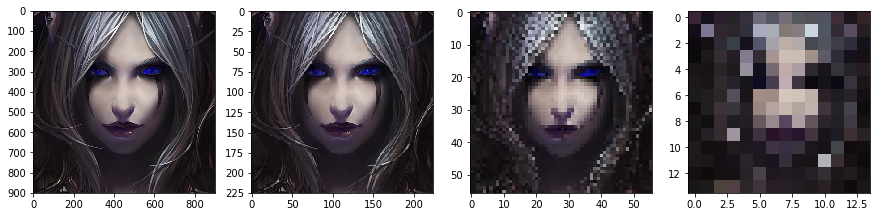

In [220]:
nos = 4 # number of sizes
f, axes = plt.subplots(1, nos, figsize = (15, 15))
for i in range(nos):
    axes[i].imshow(downsampling(sylvanas, 4 ** i))

#### Better image downsampling
Gaussian filtering first then delete even rows and even columns

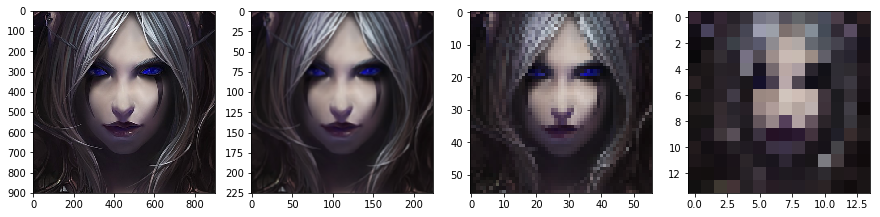

In [226]:
nos = 4 # number of sizes
f, axes = plt.subplots(1, nos, figsize = (15, 15))
for i in range(nos):
    axes[i].imshow(downsampling(sylvanas, 4 ** i, gsigma = 5, ksize = (11, 11)))

Note that image is already a discrete, sampled representation of a continuous world.

Suppose a sine wave:
- It may confuse with one of lower frequency
- It could always confuse with one of higher frquency
![url](dataset/sine_high.png)
![low](dataset/sine_low.png)

To Anti-aliasing:
1. Oversample the signal
2. Smooth the signal

Gaussian Pyramid

In [288]:
def GaussianPyramid(img, scale, nos, gsigma, ksize):
    
    m = img.shape[0]
    n = img.shape[1]
    
    output = []
    
    canvas = np.full((m, int(n * (1 + 1 / scale)) + 1,   3), 255)
    canvas[:m,:n,:] = img
    
    temp = img
    output.append(temp)
    for i in range(1, nos):
        temp = downsampling(temp, scale, gsigma, ksize)
        output.append(temp)
        canvas[int(m * (1 - 1 / scale ** (i - 1))) : int(m * (1 - 1 / scale ** (i))):, n: n + n // scale ** i , :] = temp
        
    return canvas, output

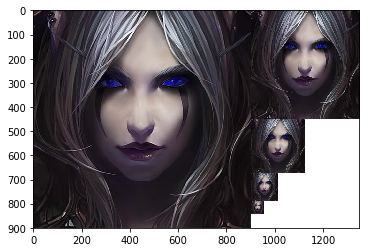

In [293]:
canvas, output = GaussianPyramid(sylvanas, 2, 5, 1, (3, 3))
plt.imshow(canvas)

Laplacian Pyramid

In [346]:
def LaplacianPyramid(img, scale, nos, gsigma, ksize):
    
    m = img.shape[0]
    n = img.shape[1]
    
    canvas = np.full((m, int(n * (1 + 1 / scale)) + 1,   3), 255, dtype = np.float32)
    
    res = []
    temp = img.astype(float)
    blurred = cv2.GaussianBlur(temp, ksize, gsigma).astype(np.float32)
    canvas[:m, :n, :] = temp - blurred
    log = temp - blurred
    temp = blurred
    res.append(log)
    for i in range(1, nos):
        temp = downsampling(temp, scale)
        blurred = cv2.GaussianBlur(temp, ksize, gsigma)
        log = temp - blurred
        temp = blurred
        res.append(log)
        canvas[int(m * (1 - 1 / scale ** (i - 1))) : int(m * (1 - 1 / scale ** (i))):, n: n + n // scale ** i , :] = log
        
    return canvas, 1   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


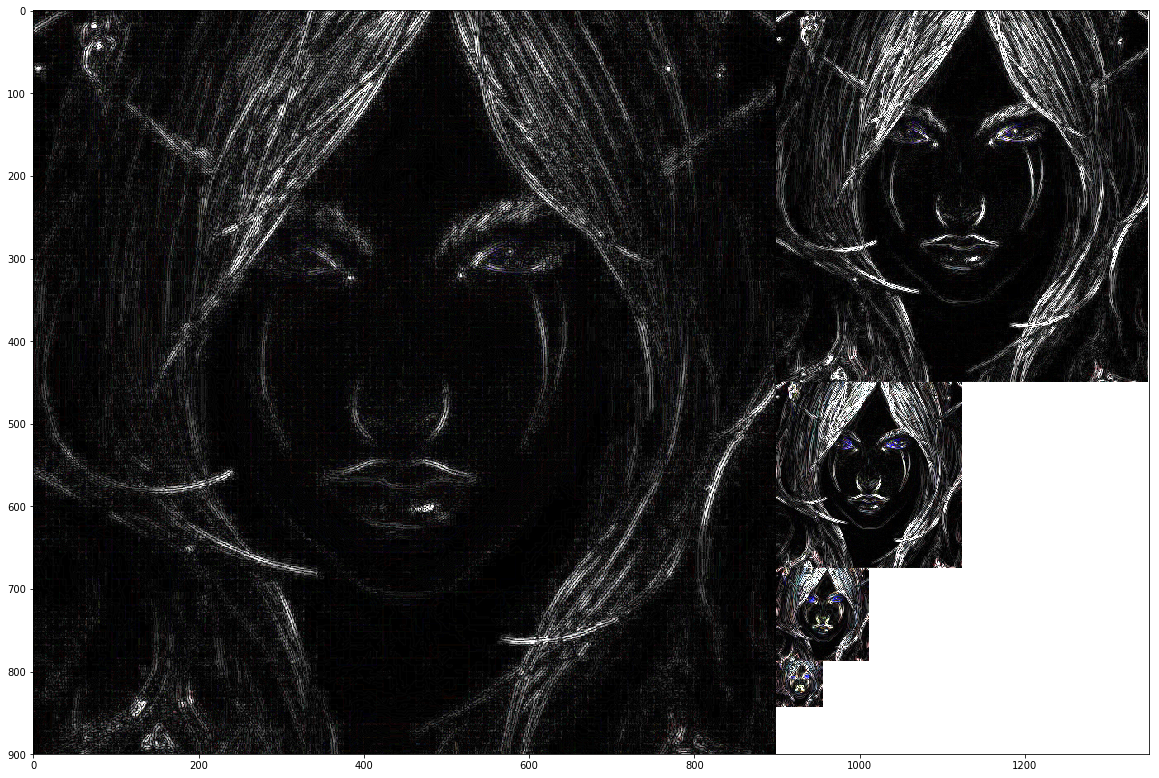

In [347]:
canvas, output= LaplacianPyramid(sylvanas, 2, 5, 1, (3, 3))
#canvas[canvas > 0] = 0 
plt.figure(figsize = (20, 20))
plt.imshow(np.abs(canvas / 15))

Others:
Steerable pyraid
Wavelets